In [1]:
import torch
import discretize_distributions as dd
from discretize_distributions.utils import calculate_w2_disc_uni_stand_normal
from discretize_distributions.discretize import GRID_CONFIGS, OPTIMAL_1D_GRIDS, w2_multi_norm_dist_for_set_locations
from discretize_distributions.grid import Grid
from matplotlib import pyplot as plt, patches, cm
from scipy.spatial import Voronoi, voronoi_plot_2d
from discretize_distributions.distributions import DiscretizedMixtureMultivariateNormal, \
    DiscretizedMixtureMultivariateNormalQuantization, DiscretizedMixtureMultivariateNormalQuantizationShell
import GMMWas
import numpy as np
from shelling_gmms import quantization_gmm_shells

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/ot/lp/cvx.py:17: UserWarning: The module ot.lp.cvx is deprecated and will be removed in future versions.The function `barycenter` was moved to ot.lp._barycenter_solvers and canbe importer via ot.lp.
  warnings.warn(


Shelling on Gaussian

In [2]:
num_dims = 2
num_mix_elems0 = 1
batch_size = torch.Size()
torch.manual_seed(1)
locs = torch.randn(batch_size + (num_mix_elems0, num_dims,))
# only diagonal and pos def covariance matrices
covariance_diag = torch.exp(torch.randn(batch_size + (num_mix_elems0, num_dims,)))
covariance_matrix = torch.diag_embed(covariance_diag)

probs = torch.rand(batch_size + (num_mix_elems0,))
probs = probs / probs.sum(dim=-1, keepdim=True)

# creates gmm with only diagonal covariances
norm = dd.MultivariateNormal(
        loc=locs,
        covariance_matrix=covariance_matrix * (1 / (np.sqrt(num_dims)))  # scaling
    )

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'discretize_distributions.distributions.multivariate_normal.MultivariateNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


W2-optimal signature for comparison of locations

In [3]:
disc_w2_optimal = dd.discretization_generator(norm, num_locs=100)  # w2 optimal grid
disc_locs = disc_w2_optimal.locs.squeeze(0)
disc_probs = disc_w2_optimal.probs.squeeze(0).detach().numpy()

Signature w2: 0.2150 / 1.4382 for grid of size: 99


Calculation of W2: 
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$


Part 1: Region inside R1

In [4]:
# shell around mean using standard deviation - but can be any region
mean = norm.mean.squeeze(0)
std = norm.stddev.squeeze(0)
shell_input = [(mean[0]-std[0], mean[0]+std[0]), (mean[1]-std[1], mean[1]+std[1])]
R1 = Grid.shell(shell_input, (10, 10))
disc_R1_locs, disc_R1_probs, w2_disc_R1 = dd.discretize_multi_norm_dist(norm, num_locs=None, grid=R1)
disc_R1_probs = disc_R1_probs.detach().numpy()  # mass in grid partitions

/Users/elizealwash/PycharmProjects/discretize_distributions/src/discretize_distributions/grid.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lower = torch.tensor(bound_lower, device=dim_locs.device, dtype=dim_locs.dtype)
/Users/elizealwash/PycharmProjects/discretize_distributions/src/discretize_distributions/grid.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper = torch.tensor(bound_upper, device=dim_locs.device, dtype=dim_locs.dtype)


Plotting

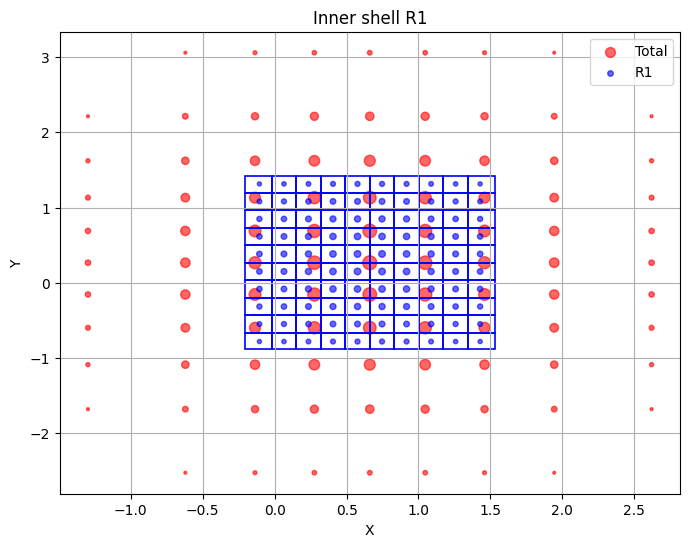

In [5]:
global_min = min(disc_R1_probs.min(), disc_probs.min())
global_max = max(disc_R1_probs.max(), disc_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s2 = (disc_R1_probs - global_min) / (global_max - global_min) * 100

core_lower_vertices_per_dim, core_upper_vertices_per_dim = R1.lower_vertices_per_dim, R1.upper_vertices_per_dim
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='Total', alpha=0.6)
ax.scatter(disc_R1_locs.detach().numpy()[:, 0], disc_R1_locs.detach().numpy()[:, 1], s=s2, color='blue', label='R1', alpha=0.6)
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
            linestyle='-'
        )
        ax.add_patch(rect)

ax.set_title('Inner shell R1')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

Part 2: Calculation of whole space $\mathbb{R}^n$ for location z

In [6]:
z = mean  # cn be arbitrary z location, choose mean as most optimal
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_inner_locs, disc_R1_inner_probs, w2_disc_R1_inner = dd.discretize_multi_norm_dist(norm, num_locs=None,
                                                                                              grid=R1_inner)
disc_R1_inner_probs = disc_R1_inner_probs.detach().numpy()  # mass in grid partitions

Part 3: Calculation of space inside boundary R1 for location z

In [7]:
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)], bounds=shell_input)

R1_lower_vertices_per_dim, R1_upper_vertices_per_dim = (R1_outer.lower_vertices_per_dim,
                                                        R1_outer.upper_vertices_per_dim)
disc_R1_outer_locs, disc_R1_outer_probs, w2_disc_R1_outer = dd.discretize_multi_norm_dist(norm, num_locs=None,
                                                                                              grid=R1_outer)
disc_R1_outer_probs = disc_R1_outer_probs.detach().numpy()  # mass in grid partitions

W2 Calculations

In [8]:
# W2 calc
print(f'W2 error R1(k): {w2_disc_R1.item()}')
print(f'W2 error outer region R^n with z: {w2_disc_R1_inner}')
print(f'W2 error inner R1 with z: {w2_disc_R1_outer.item()}')
print(f"Total W2: R1(k) + (R^n with z - R1 with z) = {w2_disc_R1.item() + (w2_disc_R1_inner-w2_disc_R1_outer.item())}")
print(f'Prob mass inside R1: {disc_R1_probs.sum()}')  
print(f'Prob mass outside R1, mass of z: 1-R1 = {1-disc_R1_probs.sum()}')

W2 error R1(k): 0.06757190823554993
W2 error outer region R^n with z: 1.4142135381698608
W2 error inner R1 with z: 0.6304727792739868
Total W2: R1(k) + (R^n with z - R1 with z) = 0.8513126373291016
Prob mass inside R1: 0.46606484055519104
Prob mass outside R1, mass of z: 1-R1 = 0.5339351892471313


Plotting

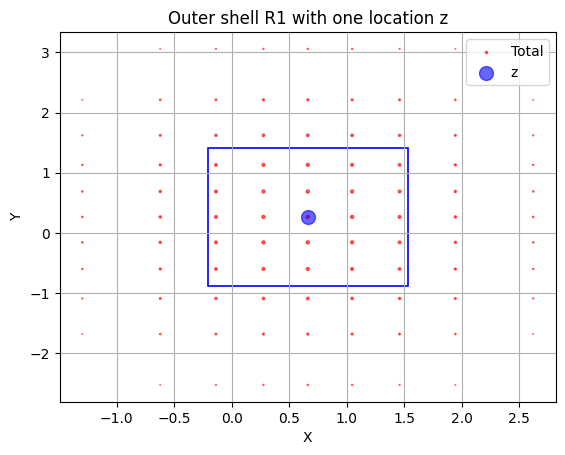

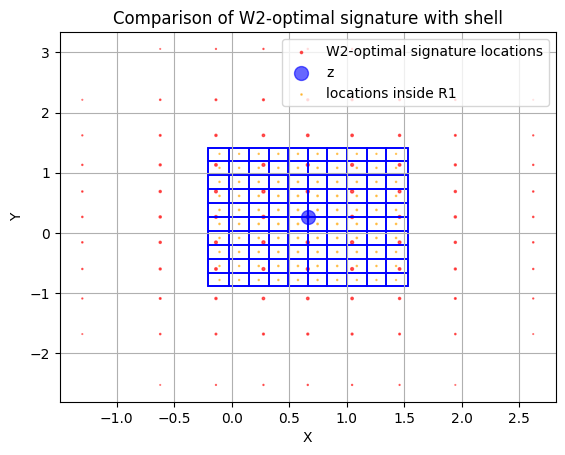

In [9]:
global_min = min(disc_R1_outer_probs.min(), disc_probs.min())
global_max = max(disc_R1_outer_probs.max(), disc_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s3 = (disc_R1_outer_probs - global_min) / (global_max - global_min) * 100

plt.figure()
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='Total',
           alpha=0.6)
ax.scatter(disc_R1_outer_locs.detach().numpy()[:, 0], disc_R1_outer_locs.detach().numpy()[:, 1],
           s=s3, color='blue', label='z',
           alpha=0.6)
x0 = R1_lower_vertices_per_dim[0].item()
x1 = R1_upper_vertices_per_dim[0].item()
y0 = R1_lower_vertices_per_dim[1].item()
y1 = R1_upper_vertices_per_dim[1].item()
rect = patches.Rectangle(
    (x0, y0),
    x1 - x0,
    y1 - y0,
    edgecolor='blue',
    facecolor='none',
    linewidth=1.2,
    linestyle='-'
)
ax.add_patch(rect)
ax.set_title('Outer shell R1 with one location z')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

# redefine prob mass relative to all grids
global_min = min(disc_R1_probs.min(), disc_probs.min(), disc_R1_outer_probs.min())
global_max = max(disc_R1_probs.max(), disc_probs.max(), disc_R1_outer_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s2 = (disc_R1_probs - global_min) / (global_max - global_min) * 100
s3 = (disc_R1_outer_probs - global_min) / (global_max - global_min) * 100

plt.figure()
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='W2-optimal signature locations',
           alpha=0.6)
ax.scatter(disc_R1_outer_locs.detach().numpy()[:, 0], disc_R1_outer_locs.detach().numpy()[:, 1],
           s=s3, color='blue', label='z',
           alpha=0.6)
ax.scatter(disc_R1_locs.detach().numpy()[:, 0], disc_R1_locs.detach().numpy()[:, 1], s=s2, color='orange', label='locations inside R1', alpha=0.6)
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
            linestyle='-'
        )
        ax.add_patch(rect)

x0 = R1_lower_vertices_per_dim[0].item()
x1 = R1_upper_vertices_per_dim[0].item()
y0 = R1_lower_vertices_per_dim[1].item()
y1 = R1_upper_vertices_per_dim[1].item()
rect = patches.Rectangle(
    (x0, y0),
    x1 - x0,
    y1 - y0,
    edgecolor='blue',
    facecolor='none',
    linewidth=1.2,
    linestyle='-'
)
ax.add_patch(rect)
ax.set_title('Comparison of W2-optimal signature with shell')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

Shelling on GMMs!

Setup:

In [10]:
num_mix_elems0 = 3
locs = torch.randn(batch_size + (num_mix_elems0, num_dims,))
# only diagonal and pos def covariance matrices
covariance_diag = torch.exp(torch.randn(batch_size + (num_mix_elems0, num_dims,)))
covariance_matrix = torch.diag_embed(covariance_diag)

probs = torch.rand(batch_size + (num_mix_elems0,))
probs = probs / probs.sum(dim=-1, keepdim=True)

gmm = dd.MixtureMultivariateNormal(
    mixture_distribution=torch.distributions.Categorical(probs=probs),
    component_distribution=dd.MultivariateNormal(
        loc=locs,
        covariance_matrix=covariance_matrix * (1 / (np.sqrt(num_dims)))  # scaling
    )
)

Each a seperate grid based on mean and std of each Gaussian component. So W2 calculation is done per component, where R1 is also defined per component:
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$
Then the W2's per component are weighted for the whole GMM, where R and C are the union of R1's and C's per component (which does not work when component's grids' overlap!):
$$
W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P},\mathbb{P}) \leq \sum^M_{i=1} \bar{\pi}_i W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P}_i, \mathbb{P}_i)
$$



In [11]:
# each separate grids
disc_gmm = DiscretizedMixtureMultivariateNormalQuantizationShell(gmm)

# stats
locs = disc_gmm.locs.detach().numpy()
probs = disc_gmm.probs.detach().numpy()
s = (probs - probs.min()) / (probs.max() - probs.min()) * 100
print(f"Total W2 error: {disc_gmm.w2.item()}")

Using separate shell logic
prob R1 sum: 0.4660648703575134
prob R1-1: 0.5339351296424866, at location: tensor([-0.6617, -0.0426])
w2 error for component 0: 0.0695238932967186
prob R1 sum: 0.4660648703575134
prob R1-1: 0.5339351296424866, at location: tensor([-1.3328,  0.5161])
w2 error for component 1: 0.06754445284605026
prob R1 sum: 0.4660648703575134
prob R1-1: 0.5339351296424866, at location: tensor([ 0.7455, -0.0751])
w2 error for component 2: 0.08636374026536942
Total W2 error: 0.08297985047101974


Plotting

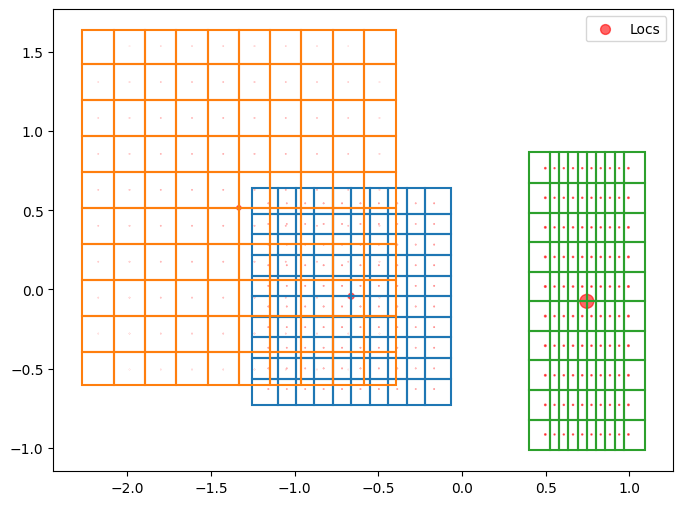

In [12]:
cmap = plt.colormaps.get_cmap('tab10')
# multiple shells
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs[:, 0], locs[:, 1], label='Locs', s=s, color='red', alpha=0.6)
for idx, R1 in enumerate(disc_gmm.R1_grids):
    core_lower_vertices_per_dim = R1.lower_vertices_per_dim
    core_upper_vertices_per_dim = R1.upper_vertices_per_dim
    color = cmap(idx % 10)
    for i in range(len(core_lower_vertices_per_dim[0])):
        for j in range(len(core_lower_vertices_per_dim[1])):
            x0 = core_lower_vertices_per_dim[0][i].item()
            x1 = core_upper_vertices_per_dim[0][i].item()
            y0 = core_lower_vertices_per_dim[1][j].item()
            y1 = core_upper_vertices_per_dim[1][j].item()

            rect = patches.Rectangle(
                (x0, y0),
                x1 - x0,
                y1 - y0,
                edgecolor=color,
                facecolor='none',
                linewidth=1.5,
                linestyle='-'
            )
            ax.add_patch(rect)
plt.legend()
plt.show()

Same grid for whole GMM. W2 calculation stays the same as before, but now it's not component wise, it's for the WHOLE distribution. So each part of the equation is found for the whole GMM using:
$$
W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P},\mathbb{P}) \leq \sum^M_{i=1} \bar{\pi}_i W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P}_i, \mathbb{P}_i)
$$
The R and C are defined by:

$$
\{\mathcal{C,R}\} := \{\{\mathcal{R}_1,\mathcal{R}_2\},\{\mathcal{C}_1,\mathcal{C}_2\}\}
$$

- The shell region $\mathcal{R}_1$ and corresponding locations inside shell $\mathcal{C}_1$
- Outer region $\mathcal{R}_2 = \mathbb{R}^n \setminus \mathcal{R}_1$ with location $\mathcal{C}_2 = z$

Then they are added/subtracted back together according to:
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$

Grid R1 setup

In [25]:
shell_input = [(torch.tensor(-1.0), torch.tensor(1.0)), (torch.tensor(-1.0), torch.tensor(1.0))]
R1_grid = Grid.shell(shell_input, (10, 10))
locs_R1 = R1_grid.get_locs()

Choose z location for whole GMM

In [26]:
locs_p = gmm.component_distribution.loc  # [num_components, dim]
z = locs_p[2, :]  # can be any arbitrary location

Calculation of W2 inside R1 region 

In [27]:
# calc w2 for R1(k)
disc_R1 = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_grid)
probs_R1, w2_R1, z_probs_R1 = disc_R1.probs, disc_R1.w2, disc_R1.z_probs   # probs already weighted by components to add to 1 ...
print(f"W2 inside R1 grid: {w2_R1}")

W2 inside R1 grid: tensor([0.1437])


Calc of W2 for outer region for location z

In [28]:
# calc w2 for R^n with z - should just be same as R1_inner with unbounded region
# w2_Rn = w2_multi_norm_dist_for_set_locations(norm=component_p, signature_locs=z)
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_outer = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_outer)
w2_R1_outer = disc_R1_outer.w2
print(f'W2 R1 outer: {w2_R1_outer}')

W2 R1 outer: tensor([1.7737])


Calc of W2 for inner region for location z

In [29]:
# calc w2 for R1 with z
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)], bounds=shell_input)
disc_R1_inner = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_inner)
w2_R1_inner = disc_R1_inner.w2
print(f'W2 R1 inner: {w2_R1_inner}')

W2 R1 inner: tensor([1.0610])


Total W2

In [30]:
# total w2 per component
# w2_p = w2_R1 + (w2_R1_outer - w2_R1_inner)
w2_squared_sum = (w2_R1.pow(2) + (w2_R1_outer.pow(2) - w2_R1_inner.pow(2)))
print(f'W2 error for whole GMM: {w2_squared_sum.sqrt().item()}')

# z location and mass
print(f'Prob R1 sum: {probs_R1.sum()}')  # equal to 1 as its weighted based on components
print(f'Prob mass of z: R1-1 = {z_probs_R1.item()}, at location: {z}')

# normalize wrt z
grid_mass = probs_R1.sum().item()
z_mass = z_probs_R1.item()  # already relative to total mass of 1
mass_scale = (1 - z_mass)   # percentage mass left over in grid
probs_R1 = probs_R1 * mass_scale
print(f'Prob mass of grid normalized by sum of grid and z: {probs_R1.sum().item()}')

locs_ = torch.cat([locs_R1, z.unsqueeze(0)], dim=0)
probs_ = torch.cat([probs_R1, z_probs_R1], dim=0)  # need to normalize ?
print(f'Total probs: {probs_.sum()}')

W2 error for whole GMM: 1.4286922216415405
Prob R1 sum: 1.0
Prob mass of z: R1-1 = 0.4717707633972168, at location: tensor([ 0.7455, -0.0751])
Prob mass of grid normalized by sum of grid and z: 0.5282292366027832
Total probs: 1.0


Plotting

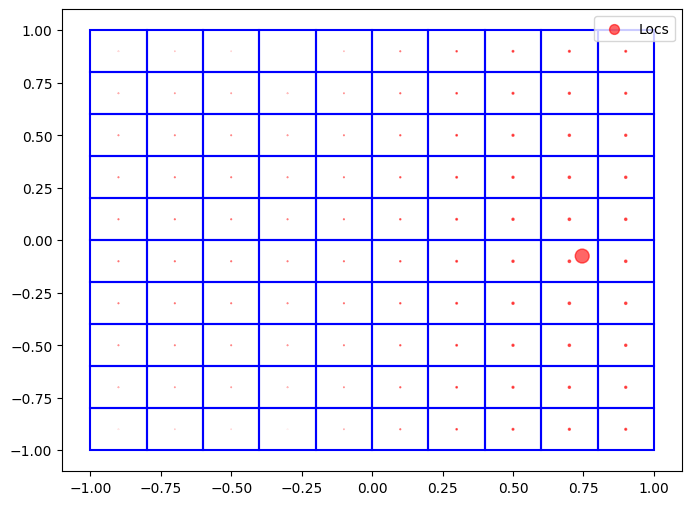

In [31]:
s = (probs_ - probs_.min()) / (probs_.max() - probs_.min()) * 100
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs_[:, 0], locs_[:, 1], label='Locs', s=s, color='red', alpha=0.6)
core_lower_vertices_per_dim = R1_grid.lower_vertices_per_dim
core_upper_vertices_per_dim = R1_grid.upper_vertices_per_dim
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.5,
            linestyle='-'
        )
        ax.add_patch(rect)
plt.legend()
plt.show()

Test 1: If R1 = whole space so R^n then the upper bound is only dependent on R1(k)

In [32]:
# test - if R1 is whole space
R1_grid = Grid.from_shape((10, 10), torch.Tensor(((-2.5, 0.0), (-0.8, 1.5))))  # no bounds on grid
locs_R1 = R1_grid.get_locs()

# component
z = locs_p[2, :]  # can be any arbitrary location

# calc w2 for R1(k)
disc_R1 = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_grid)
probs_R1, w2_R1, z_probs_R1 = disc_R1.probs, disc_R1.w2, disc_R1.z_probs  
print(f"W2 inside R1 grid: {w2_R1}")

# calc w2 for R^n with z - should just be same as R1_inner with unbounded region
# w2_Rn = w2_multi_norm_dist_for_set_locations(norm=component_p, signature_locs=z)
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_outer = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_outer)
w2_R1_outer = disc_R1_outer.w2
print(f'W2 R1 outer: {w2_R1_outer}')

# calc w2 for R1 with z
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])  # no bounds
disc_R1_inner = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_inner)
w2_R1_inner = disc_R1_inner.w2
print(f'W2 R1 inner: {w2_R1_inner}')

# total w2 per component
# w2_p = w2_R1 + (w2_R1_outer - w2_R1_inner)
w2_squared_sum = (w2_R1.pow(2) + (w2_R1_outer.pow(2) - w2_R1_inner.pow(2)))
print(f'W2 error for whole GMM: {w2_squared_sum.sqrt().item()}')

W2 inside R1 grid: tensor([2.1346])
W2 R1 outer: tensor([1.7737])
W2 R1 inner: tensor([1.7737])
W2 error for whole GMM: 2.134634017944336


Test 2: R1(k) = R1 and ck=z, then the upper bound is only dependent on the space R^n

In [33]:
# test - if R1(k)=R1 and ck=z 
shell_input = [(torch.tensor(-1.0), torch.tensor(1.0)), (torch.tensor(-1.0), torch.tensor(1.0))]

z = locs_p[2, :]  # can be any arbitrary location
R1_grid = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)], bounds=shell_input)

# calc w2 for R1(k)
disc_R1 = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_grid)
probs_R1, w2_R1, z_probs_R1 = disc_R1.probs, disc_R1.w2, disc_R1.z_probs  
print(f"W2 inside R1 grid: {w2_R1}")

# calc w2 for R^n with z - should just be same as R1_inner with unbounded region
# w2_Rn = w2_multi_norm_dist_for_set_locations(norm=component_p, signature_locs=z)
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_outer = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_outer)
w2_R1_outer = disc_R1_outer.w2
print(f'W2 R1 outer: {w2_R1_outer}')

# calc w2 for R1 with z
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)],  bounds=shell_input)
disc_R1_inner = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_inner)
w2_R1_inner = disc_R1_inner.w2
print(f'W2 R1 inner: {w2_R1_inner}')

# total w2 per component
# w2_p = w2_R1 + (w2_R1_outer - w2_R1_inner)
w2_squared_sum = (w2_R1.pow(2) + (w2_R1_outer.pow(2) - w2_R1_inner.pow(2)))
print(f'W2 error for whole GMM: {w2_squared_sum.sqrt().item()}')

W2 inside R1 grid: tensor([1.0610])
W2 R1 outer: tensor([1.7737])
W2 R1 inner: tensor([1.0610])
W2 error for whole GMM: 1.773738145828247


For multiple shells, the R and C are defined by:
$$
\{\mathcal{C,R}\} := \{\{\mathcal{R}_1,\mathcal{R}_2\},\{\mathcal{C}_1,\mathcal{C}_2\}\}
$$
Let $\mathcal{R}_1 = \{\mathcal{R}_n \mid n = 1, \dots, N\}$ be a collection of \textbf{disjoint} shell regions, and let $\mathcal{C}_1 = \{\mathcal{C}_n \mid n = 1, \dots, N\}$ denote the corresponding sets of discretized locations within each shell. Then the outer region is defined by $\mathcal{R}_2 = \mathbb{R}^n \setminus \mathcal{R}_n$ with location $\mathcal{C}_2 = z$, for each inner region $\mathcal{R}_n$. 

Then they are added/subtracted back together according to:
$$
W_2^2(\mathbb{P}, \Delta_{\mathcal{R}, \mathcal{C}} \# \mathbb{P}) 
\leq 
\sum_{n=1}^N \int_{\mathcal{R}_{n,k}} \|x - c_k\|^2 \, d\mathbb{P}(x)
+ \int_{\mathbb{R}^n \setminus \mathcal{R}_n} \|x - z\|^2 \, d\mathbb{P}(x) - \int_{\mathcal{R}_{n}} \|x - z\|^2 \, d\mathbb{P}(x)
$$

In [34]:
# multiple shells on one gmm - function
shell_inputs = [
    [(torch.tensor(-1.0), torch.tensor(-0.6)), (torch.tensor(-1.0), torch.tensor(-0.6))],
    [(torch.tensor(-0.5), torch.tensor(1.0)), (torch.tensor(-0.5), torch.tensor(1.0))],
    [(torch.tensor(-1.5), torch.tensor(-1.1)), (torch.tensor(-1.5), torch.tensor(-1.1))]
]
resolutions = [(3, 3), (10, 10), (4, 4)]
padding = [0.05, 0.1, 0.05]

probs_all, locs_all, total_w2, all_R1_grids = quantization_gmm_shells(
    gmm=gmm,
    z=z,
    shell_inputs=shell_inputs,
    resolutions=resolutions,
    paddings=padding)

print(f"Total W2 error over all shells: {total_w2}")

Shell bounds: [(tensor(-1.), tensor(-0.6000)), (tensor(-1.), tensor(-0.6000))]
Prob mass of z: 0.9948123097419739
Prob mass of grid: 1.0
Prob mass of grid normalized by sum of grid and z: 0.005187690258026123
Shell bounds: [(tensor(-0.5000), tensor(1.)), (tensor(-0.5000), tensor(1.))]
Prob mass of z: 0.6257296800613403
Prob mass of grid: 0.9999999403953552
Prob mass of grid normalized by sum of grid and z: 0.3742702603340149
Shell bounds: [(tensor(-1.5000), tensor(-1.1000)), (tensor(-1.5000), tensor(-1.1000))]
Prob mass of z: 0.998589813709259
Prob mass of grid: 1.0
Prob mass of grid normalized by sum of grid and z: 0.0014101862907409668
Total W2 error: 2.822803258895874
Total W2 error over all shells: 2.822803258895874


Plotting

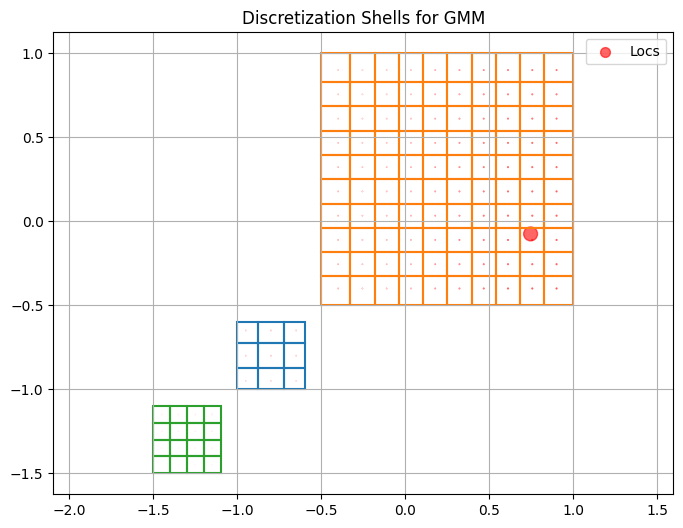

In [35]:
s = (probs_all - probs_all.min()) / (probs_all.max() - probs_all.min()) * 100
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs_all[:, 0], locs_all[:, 1], label='Locs', s=s, color='red', alpha=0.6)  # locs
cmap = plt.colormaps.get_cmap('tab10')
for idx, R1 in enumerate(all_R1_grids):
    color = cmap(idx % 10)
    core_lower_vertices_per_dim = R1.lower_vertices_per_dim
    core_upper_vertices_per_dim = R1.upper_vertices_per_dim
    for i in range(len(core_lower_vertices_per_dim[0])):
        for j in range(len(core_lower_vertices_per_dim[1])):
            x0 = core_lower_vertices_per_dim[0][i].item()
            x1 = core_upper_vertices_per_dim[0][i].item()
            y0 = core_lower_vertices_per_dim[1][j].item()
            y1 = core_upper_vertices_per_dim[1][j].item()
            rect = patches.Rectangle(
                (x0, y0),
                x1 - x0,
                y1 - y0,
                edgecolor=color,
                facecolor='none',
                linewidth=1.5,
                linestyle='-'
            )
            ax.add_patch(rect)
plt.title("Discretization Shells for GMM")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

Verify results with previous implementation for just one shell 

Shell bounds: [(tensor(-1.), tensor(1.)), (tensor(-1.), tensor(1.))]
Prob mass of z: 0.4717707633972168
Prob mass of grid: 1.0
Prob mass of grid normalized by sum of grid and z: 0.5282292366027832
Total W2 error: 1.4286922216415405
Total W2 error over all shells: 1.4286922216415405


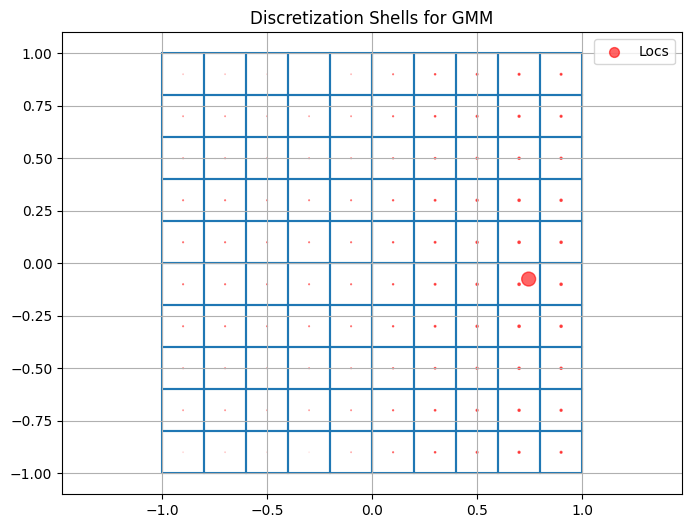

In [36]:
shell_inputs = [[(torch.tensor(-1.0), torch.tensor(1.0)), (torch.tensor(-1.0), torch.tensor(1.0))]]
resolutions = [(10, 10)]
paddings = [0.1]
probs_all, locs_all, total_w2, all_R1_grids = quantization_gmm_shells(
    gmm=gmm,
    z=z,
    shell_inputs=shell_inputs,
    resolutions=resolutions,
    paddings=paddings)

print(f"Total W2 error over all shells: {total_w2}")
s = (probs_all - probs_all.min()) / (probs_all.max() - probs_all.min()) * 100
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs_all[:, 0], locs_all[:, 1], label='Locs', s=s, color='red', alpha=0.6)  # locs
cmap = plt.colormaps.get_cmap('tab10')
for idx, R1 in enumerate(all_R1_grids):
    color = cmap(idx % 10)
    core_lower_vertices_per_dim = R1.lower_vertices_per_dim
    core_upper_vertices_per_dim = R1.upper_vertices_per_dim
    for i in range(len(core_lower_vertices_per_dim[0])):
        for j in range(len(core_lower_vertices_per_dim[1])):
            x0 = core_lower_vertices_per_dim[0][i].item()
            x1 = core_upper_vertices_per_dim[0][i].item()
            y0 = core_lower_vertices_per_dim[1][j].item()
            y1 = core_upper_vertices_per_dim[1][j].item()
            rect = patches.Rectangle(
                (x0, y0),
                x1 - x0,
                y1 - y0,
                edgecolor=color,
                facecolor='none',
                linewidth=1.5,
                linestyle='-'
            )
            ax.add_patch(rect)
plt.title("Discretization Shells for GMM")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()